In [3]:
!pip install pymorphy3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 31.9 MB/s eta 0:00:00


In [18]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import re

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pymorphy3 import MorphAnalyzer
from sklearn.model_selection import train_test_split
from typing import List
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_ru = set(stopwords.words('russian'))
patterns = re.compile(
    r'\.|\,|\!|\?|\;|\:|\(|\)|\&|\=|\<|\>|\[|\]|\{|\}|\~|\`|\"|\'|'
    r'\/|\\|\||\-'
)
morph = MorphAnalyzer()
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/lab_5_python/file_csv.csv')
df = df.drop(df.columns[[0]], axis = 1)
df.iloc[:,0]-=1
df = df.dropna()
print(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive
      num                                               text
0       0             закрытая информация по моим же деньгам
1       0  Как Сбербанк обманывает клиентов и почему не с...
2       0                      Деньги до сих пор не вернули!
3       0                      Право то есть, да совести нет
4       0  Театр абсурда или как мне выпускали банковскую...
...   ...                                                ...
4186    4                                       Мне нравится
4187    4                                        Лучший банк
4188    4                                      Отличный банк
4189    4                                        Лучший банк
4190    4                                           Мой сбер

[4191 rows x 2 columns]


In [60]:
def lemmatize(review: str) -> List[str]:
    review = re.sub(patterns, ' ', review)
    tokens = nltk.word_tokenize(review.lower())
    preprocessed_text = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form
        if lemma not in stopwords_ru:
            preprocessed_text.append(lemma)
    return preprocessed_text
df['text'] = df['text'].apply(lemmatize)
print(df.head())

   num                                               text
0    0                     [закрытый, информация, деньга]
1    0  [сбербанк, обманывать, клиент, почему, стоить,...
2    0                       [деньга, сей, пора, вернуть]
3    0                                   [право, совесть]
4    0      [театр, абсурд, выпускать, банковский, карта]


In [61]:
def join_lemmatized_words(words_list: list) -> str:
    return ' '.join(words_list)
df['text'] = df['text'].apply(join_lemmatized_words)
print(df)

      num                                               text
0       0                         закрытый информация деньга
1       0  сбербанк обманывать клиент почему стоить связы...
2       0                            деньга сей пора вернуть
3       0                                      право совесть
4       0            театр абсурд выпускать банковский карта
...   ...                                                ...
4186    4                                          нравиться
4187    4                                       хороший банк
4188    4                                      отличный банк
4189    4                                       хороший банк
4190    4                                               сбер

[4191 rows x 2 columns]


In [12]:
vectorizer = CountVectorizer(max_features=2827)
sparse_matrix = vectorizer.fit_transform(df['text']).toarray()

x_train, x_test_valid, y_train, y_test_valid = train_test_split(sparse_matrix, np.array(df['num']), test_size=0.2)
x_test, x_valid, y_test, y_valid = train_test_split(x_test_valid, y_test_valid, test_size=0.5)
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1330, 1: 427, 2: 531, 3: 482, 4: 582}


In [13]:
max_words = 31887
cv = CountVectorizer(max_features=max_words)
sparse_matrix = cv.fit_transform(df['text']).toarray()
feature_names = cv.get_feature_names_out()
words = feature_names.tolist()

print(feature_names)
print(sparse_matrix.shape)

['00' '000' '01080' ... 'якобы' 'яндекс' 'яркий']
(4191, 4569)


In [14]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(2827, 150)
        self.linear2 = nn.Linear(150, 15)
        self.linear3 = nn.Linear(15, 5)

    def forward(self, x: torch.Tensor):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.softmax(x, dim=1)

In [15]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

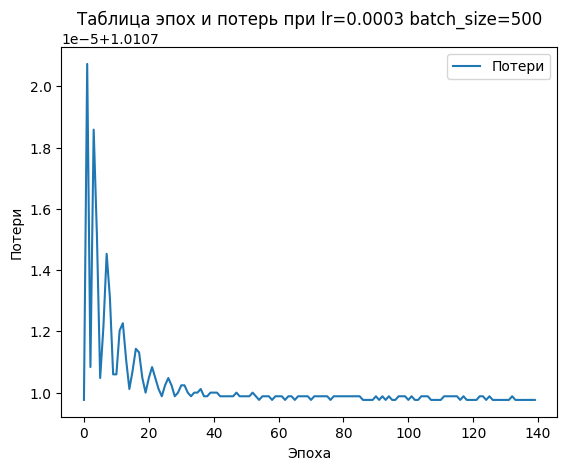

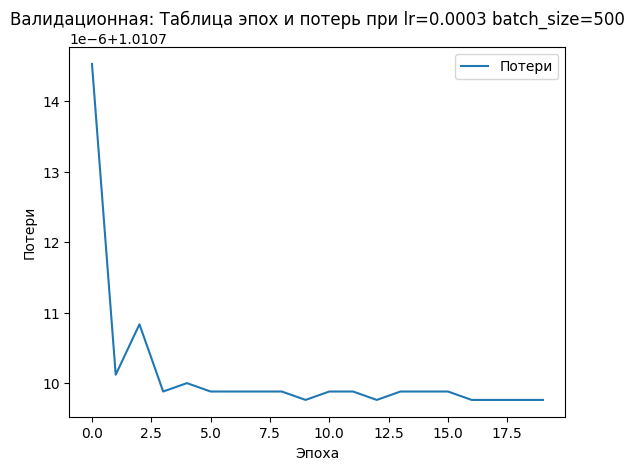

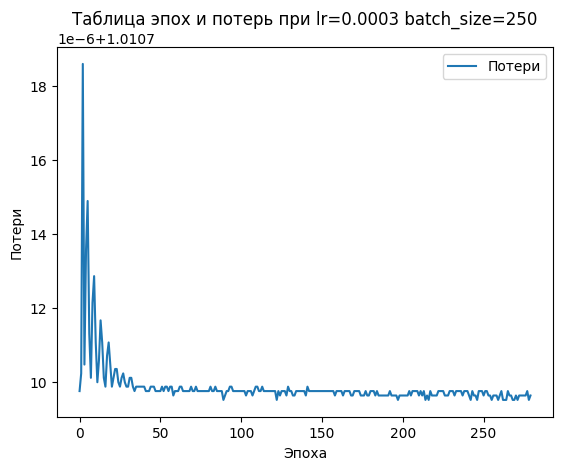

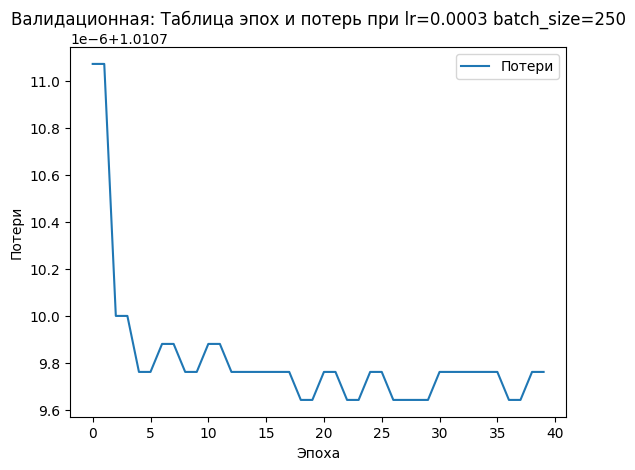

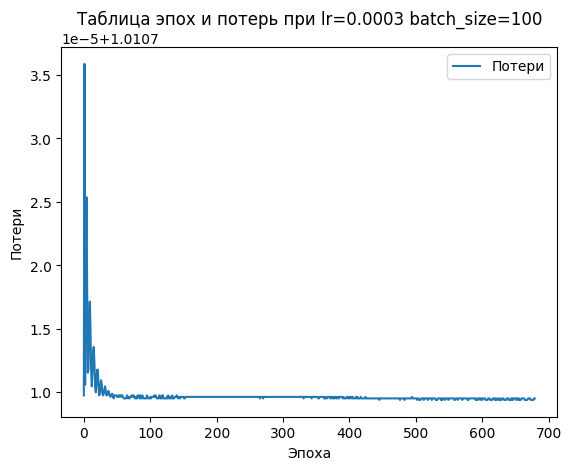

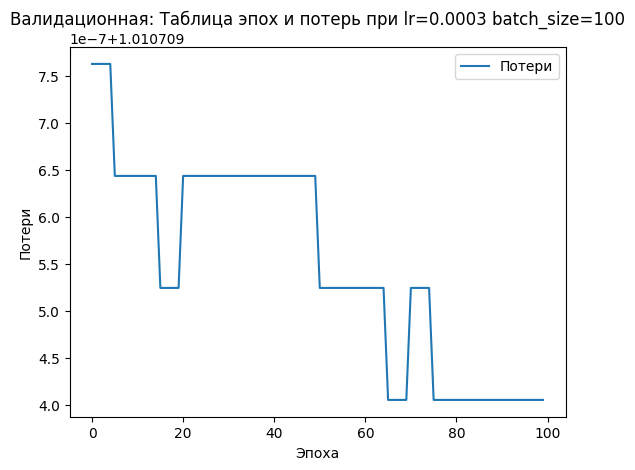

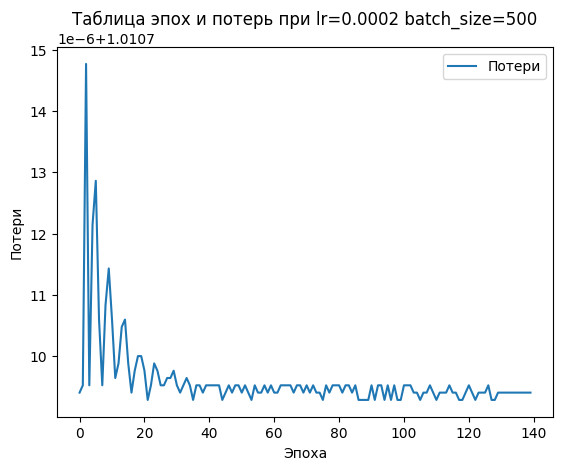

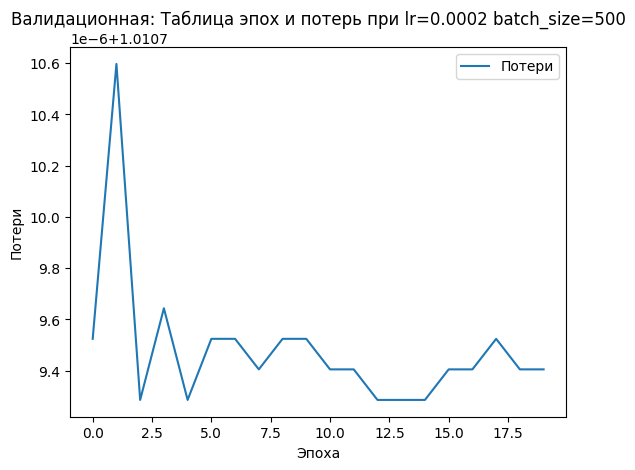

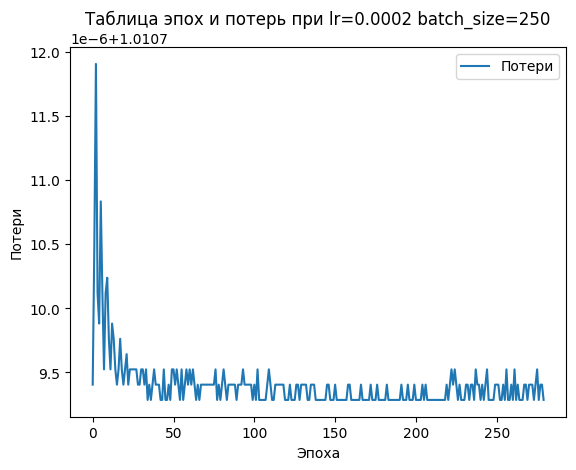

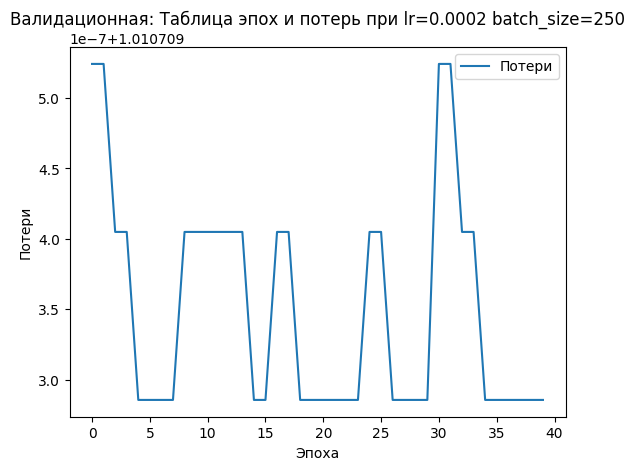

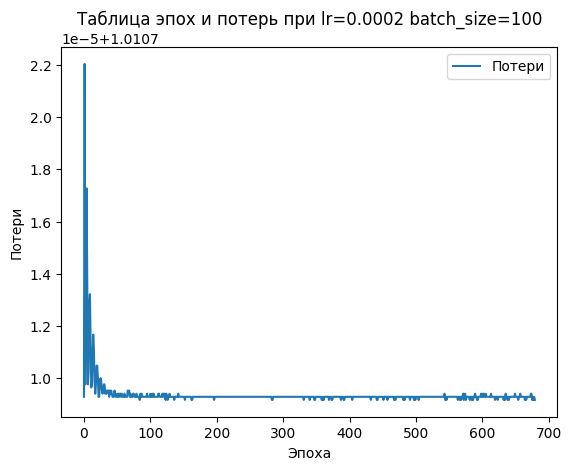

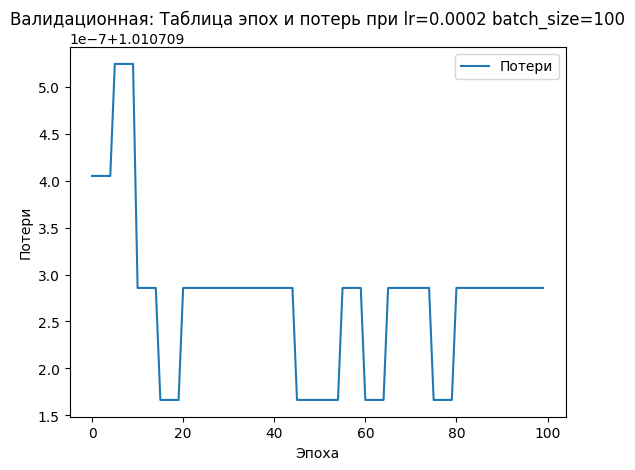

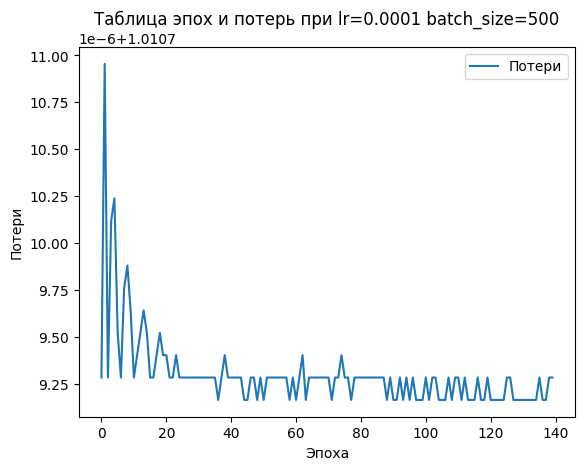

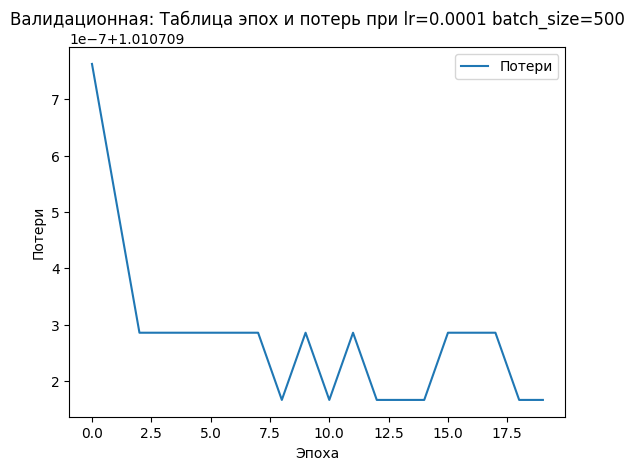

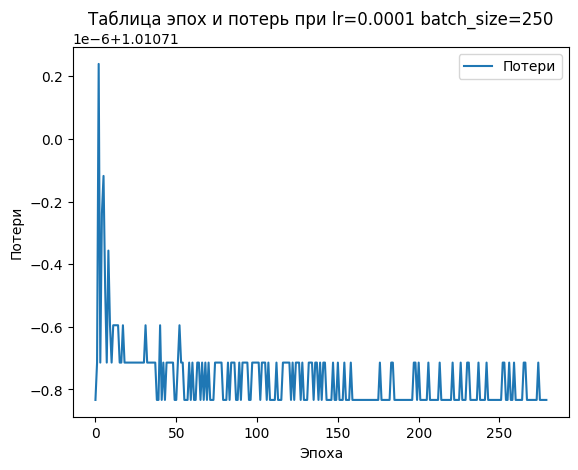

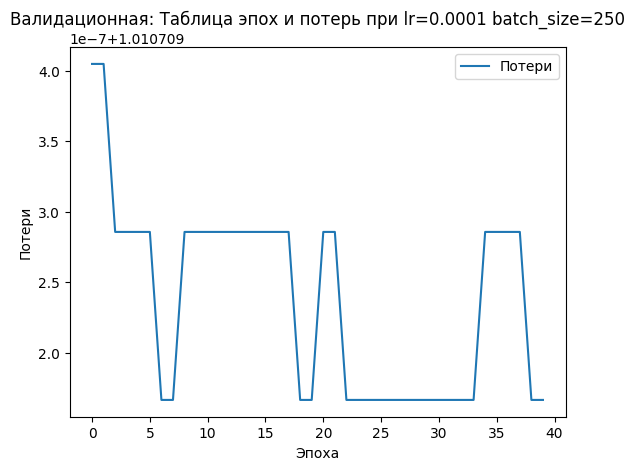

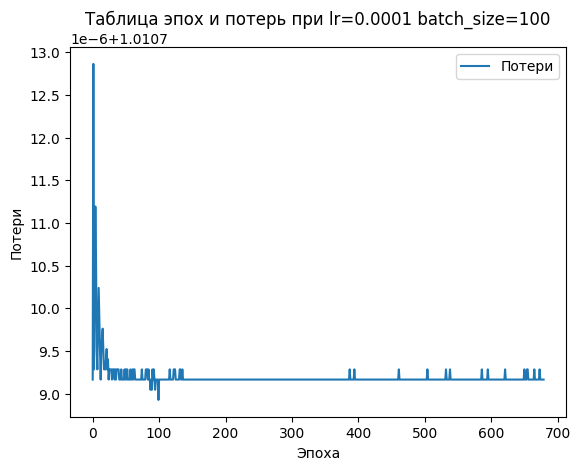

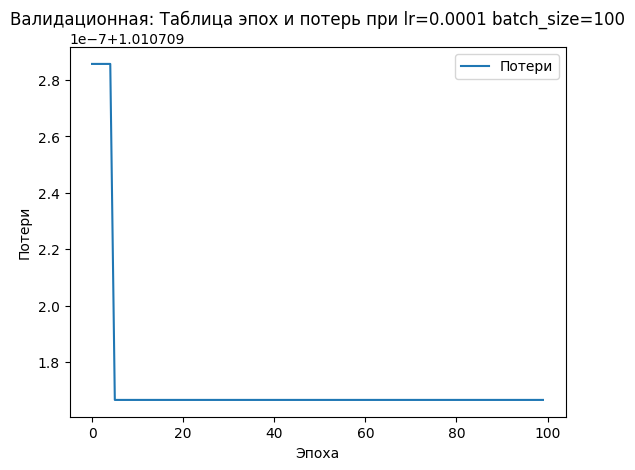

In [18]:
learning_rate = [0.0003, 0.0002, 0.0001]
batch_size = [500, 250, 100]
for lr in learning_rate:
  for bs in batch_size:
      data = torch.utils.data.DataLoader(x_train, batch_size=bs, shuffle=True)
      val_data = torch.utils.data.DataLoader(x_valid, batch_size=bs, shuffle=True)
      optimizer = torch.optim.Adam(params=model.parameters() , lr=lr)
      epochs = 20
      model.train()
      loss_test = []
      loss_val=[]
      for epoch in range(epochs):
       for elem in data:
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss_test.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       model.eval()
       for elem in val_data:
         y_pred = model(x_train)
         loss = criterion(y_pred, y_train)
         loss_val.append(loss.item())

      plt.plot(loss_test)
      plt.title('Таблица эпох и потерь при lr='+str(lr) +" batch_size="+str(bs))
      plt.xlabel('Эпоха')
      plt.ylabel('Потери')
      plt.legend(['Потери'])
      plt.show()


      plt.plot(loss_val)
      plt.title('Валидационная: Таблица эпох и потерь при lr='+str(lr) +" batch_size="+str(bs))
      plt.xlabel('Эпоха')
      plt.ylabel('Потери')
      plt.legend(['Потери'])
      plt.show()

In [19]:
x_test = torch.Tensor(x_test).float()
y_test = torch.Tensor(y_test).long()
model.eval()
with torch.no_grad():
    for i in range(10):
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)
        pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print("Accuracy : {}%".format(100 * pred / len(x_test)))

Accuracy : 55.131263732910156%


In [24]:
torch.save(model.state_dict(), '/content/drive/MyDrive/lab_5_python/model.pt')

In [25]:
new_model = LogisticRegression()
new_model.load_state_dict(torch.load('/content/drive/MyDrive/lab_5_python/model.pt'))

<All keys matched successfully>

In [26]:
print(df["text"][3005])
new_review_vectorized = vectorizer.transform([df["text"][3005]]).toarray()
new_model.eval()
with torch.no_grad():
    pred_y = new_model(torch.Tensor(new_review_vectorized))
    print(pred_y)

Удобно в цифровом формате
tensor([[1.8919e-20, 8.8981e-10, 7.4288e-16, 1.0000e+00, 3.8169e-08]])
